In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('/global/homes/m/mehdi/github/DESILSS')
import fitsio as ft
import healpy as hp
import numpy as np

In [2]:
d = ft.read('/global/cscratch1/sd/mehdi/eboss/ELG_hpsyst.density.nside256.eboss22.fits')
for di in d.dtype.names:print('{} '.format(di), end=' \n')

hpind  
hpra  
hpdec  
hpgaiastardens  
hpebv  
hpnobs_g  
hpnobs_r  
hpnobs_z  
hppsfdepth_g  
hppsfdepth_r  
hppsfdepth_z  
hpgaldepth_g  
hpgaldepth_r  
hpgaldepth_z  
hppsfsize_g  
hppsfsize_r  
hppsfsize_z  
hpweight_lin  
random_photo  
density_photo  
NGC  
SGC  
eboss21  
eboss22  
eboss23  
eboss25  


In [3]:
features = ['hpgaiastardens', 'hpebv'] \
         + [s+'_'+b for s in ['hppsfdepth', 'hpgaldepth', 'hppsfsize'] for b in 'rgz']
print('# phot. maps to be regressed on : \n {}'.format(features))

# phot. maps to be regressed on : 
 ['hpgaiastardens', 'hpebv', 'hppsfdepth_r', 'hppsfdepth_g', 'hppsfdepth_z', 'hpgaldepth_r', 'hpgaldepth_g', 'hpgaldepth_z', 'hppsfsize_r', 'hppsfsize_g', 'hppsfsize_z']


Prepare the data for the NN

In [4]:
mask     = d['eboss22'].astype('bool')
label    = d['density_photo'][mask]
Features = []
for f in features:
    Features.append(d[f][mask])
Features = np.column_stack(Features)

print('shape of Features ', Features.shape)
print('shape of label', label.shape)

shape of Features  (8866, 11)
shape of label (8866,)


Look at the mean and std of features

In [5]:
for m in range(Features.shape[1]):
    print('sys {:15s}:  mean :   {:8.3f}, std:  {:8.3f}'\
          .format(features[m], np.mean(Features[:,m]), np.std(Features[:, m])))

sys hpgaiastardens :  mean :    446.362, std:    98.905
sys hpebv          :  mean :      0.034, std:     0.016
sys hppsfdepth_r   :  mean :   2073.811, std:  1167.782
sys hppsfdepth_g   :  mean :   2643.799, std:  1841.580
sys hppsfdepth_z   :  mean :    236.420, std:   193.237
sys hpgaldepth_r   :  mean :   1130.868, std:   591.094
sys hpgaldepth_g   :  mean :   1666.482, std:  1069.887
sys hpgaldepth_z   :  mean :    116.833, std:    89.619
sys hppsfsize_r    :  mean :        nan, std:       nan
sys hppsfsize_g    :  mean :        nan, std:       nan
sys hppsfsize_z    :  mean :        nan, std:       nan


In [6]:
np.isnan(Features[:, 10]).sum()

25

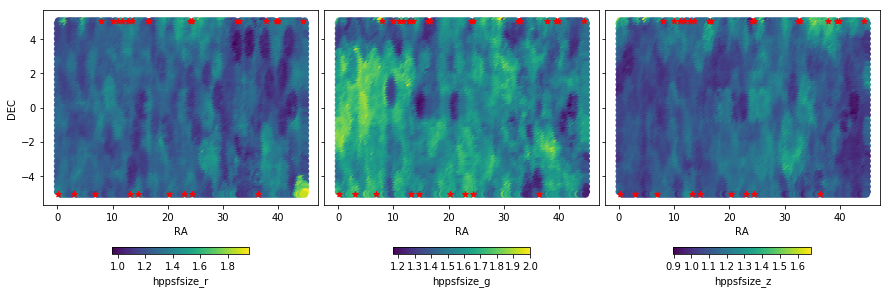

In [7]:
bands= ['r','g', 'z']
f,ax = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
plt.subplots_adjust(wspace=0.02, top=.9)
for i in range(3):
    name = 'hppsfsize_'+bands[i]
    masknan = np.isnan(d[name])  & mask
    m1 = ax[i].scatter(d['hpra'][mask], d['hpdec'][mask], c=d[name][mask])
    ax[i].scatter(d['hpra'][masknan], d['hpdec'][masknan], c='red', marker='*')
    cb = f.colorbar(m1, ax=ax[i], shrink=0.5, orientation='horizontal')
    cb.set_label(name)
    ax[i].set_xlabel('RA')
    ax[0].set_ylabel('DEC')

In [8]:
for b in 'rgz':
    print(np.argwhere(np.isnan(d['hppsfsize_'+b][mask])).flatten())

[  22   28   31   33   36   38   46   47   68   69   92   93  107  112
  113  126 8738 8746 8757 8775 8779 8795 8803 8807 8841]
[  22   28   31   33   36   38   46   47   68   69   92   93  107  112
  113  126 8738 8746 8757 8775 8779 8795 8803 8807 8841]
[  22   28   31   33   36   38   46   47   68   69   92   93  107  112
  113  126 8738 8746 8757 8775 8779 8795 8803 8807 8841]


In [11]:
np.isnan(d['hppsfsize_g'][d['eboss22']]).sum()

25

(array([  73.,  362.,  816., 1604., 2398., 1950., 1115.,  426.,   93.,
           4.]),
 array([1.1656496 , 1.24941052, 1.33317144, 1.41693236, 1.50069329,
        1.58445421, 1.66821513, 1.75197606, 1.83573698, 1.9194979 ,
        2.00325882]),
 <a list of 10 Patch objects>)

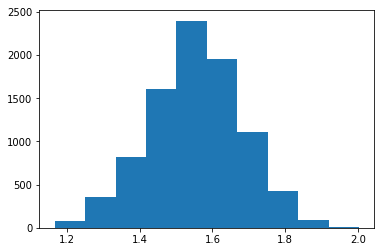

In [15]:
plt.hist(d['hppsfsize_g'][mask & (~masknan)])

In [16]:
np.median(d['hppsfsize_g'][mask & (~masknan)]), np.mean(d['hppsfsize_g'][mask & (~masknan)])

(1.5556948781013489, 1.5543010771588626)